<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/boris-htan/HTAN/Python%20Notebooks/Analyzing_HTAN_spatial_data_with_BigQuery_geospatial_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing HTAN spatial data with BigQuery spatial analytics

        Title:   Analyzing HTAN spatial data with BigQuery geospatial analytics
        Author:  Boris Aguilar (baguilar@systemsbiology.org) & Vesteinn Thorson
        Created: 02/14/2024
        Purpose: Provide examples of how BigQuery geospatial analytics can be used to analyze spatial data in HTAN.
        URL:     NA
        Notes:   NA

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease. [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

[BigQuery Geospatial analytics](https://cloud.google.com/bigquery/docs/geospatial-intro) allows you to easily and efficiently analyze and visualize geospatial data in Google BigQuery.  

### 1.1 Goal

This notebook provides examples of how BigQuery spatial analytics can help us analyze and explore spatial data available in HTAN BigQuery tables.

### 1.2 Inputs, Outputs, & Data

This notebook uses HTAN spatial transcriptomics data from Melanoma samples available  in the [ISB-CGC](https://isb-cgc.appspot.com/). Specifically, we will be using the following public BigQuery table [isb-cgc-bq.HTAN.imaging_level4_HMS_mel_mask_current](https://console.cloud.google.com/bigquery?p=isb-cgc-bq&d=HTAN&t=imaging_level4_HMS_mel_mask_current&page=table)




# 2. Environment and Module setup

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
import pandas_gbq
from google.colab import auth

# 3. Google Authentication:

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following:
auth.authenticate_user()

# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [ ]:
# create a client object to be able to read and write BigQuery tables
project_id = "cgc-05-0042"
client = bigquery.Client(project_id)

# 4. Exploration and analysis of HTAN spatial data with BigQuery

We will focus on imaging data of sample MEL1-1 described in [the manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and). This tissue section is HTAN biospecimen HTA7_1_3.

The necessary data is located in the BigQuery table isb-cgc-bq.HTAN.imaging_level4_HMS_crc_mask_current. This table contains estimated marker intensities following cell segmentation. The table also contains data on location of segmented cells. Here we will use the cell locations in terms of the centroids X_centroid and Y_centroid which represent location coordinated of cells in pixels ( 1 pixel corresponds to 0.55 micrometers).

## 4.1 Labeling tumor cells
First, we will label cancer cells in the samples. According to the manuscript, cancer cells have positive SOX10. They also should have positivoe  S100B and/or positive CD63. We can do this by using some threshold for the expresion of these markers. We calibrated this treshold manually; but the manuscript provides more details about how to identify cell types from marker.  

Finally we will focus on a spetial region of HTA7_1_3  called  Invasive Melanoma (IM) which has the following corner coordiantes: ( 23076.9, 9615.3) and  (30384.6, 15000).


The follow query is an example of how to label tumor cells using the required markers which are in columns  S100B_cellRingMask, S100B_cellRingMask, CD63_cellRingMask :

In [ ]:
query = """
WITH cells AS (
  SELECT  CellID, X_centroid,	Y_centroid,
    IF ( SOX10_cellRingMask > 3704.5 AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 ),
      'Tumor', 'Other'  ) AS celltype
  FROM `isb-cgc-bq.HTAN.imaging_level4_HMS_mel_mask_current`
  WHERE HTAN_Biospecimen_ID = 'HTA7_1_3'
)
SELECT CellID, X_centroid,	Y_centroid, celltype
FROM cells
WHERE X_centroid > 23076.9 AND X_centroid < 30384.6
  AND Y_centroid > 9615.3 AND Y_centroid < 15000
"""
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████|


,CellID,X_centroid,Y_centroid,celltype
0,417418,30373.027523,11525.807339,Other
1,418102,28940.358491,11532.094340,Other
2,418601,28041.960784,11541.986928,Other
3,418820,29201.471429,11542.771429,Other
4,418993,27769.416667,11544.635417,Other
...,...,...,...,...
101113,640586,24725.802198,14180.780220,Tumor
101114,641388,26349.666667,14187.716049,Tumor
101115,641566,24366.497354,14191.259259,Tumor
101116,641849,26232.053030,14191.969697,Tumor


The following code generates an image of the location of Tumor and Other cells from the above dataframe. This image is similar to Figure 3A of the [manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and).  

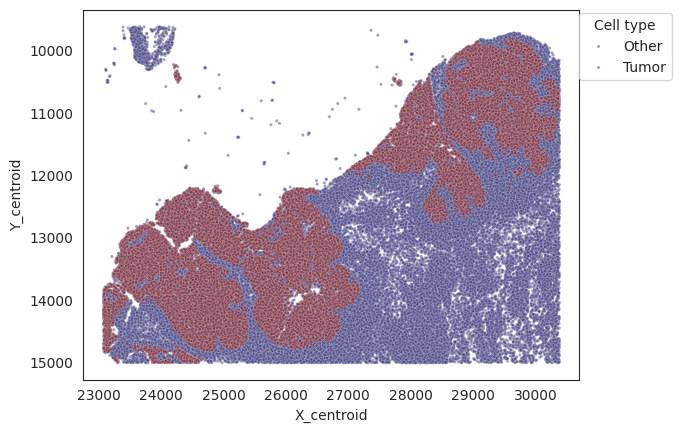

In [ ]:
# Set the seaborn theme
sns.set_style("white")

# Let's plot the centroids and color them by marker first:
g=sns.scatterplot(y="Y_centroid", x="X_centroid", hue='celltype', s=5,  data=df, alpha = 0.5, palette="icefire")

sns.move_legend(g, "upper right", title='Cell type',  bbox_to_anchor=(1.2, 1.01))
plt.axis('equal')
g.invert_yaxis() # Flip the y-axis so it aligns with the figure in the publication

# 4.2 Computing local neighborhoods using BigQuery Geospatial analytics

Often spatial analysis requires the ideintification of neighboring cells, which are cellpairs that are closer than a threhold distance. Here use BigQuery spatial analytics to identify neighboring cells for each tumor cell.   

BigQuery uses distances in spherical coordinates, so we need to rescale the pixel coordinates to latitude and longitude. We found that a good approximation is to assume that maximum dimension of the image in pixels corresponds to 0.1 earth degrees. The HTA7_1_3 images has dimentions of (36857,25808) pixels. Thus we rescaled the cell cordinates by 1/368570. Moreover with this assumtion 20 um is equivalent to 9.29324770787722 meters, which is used as threshold in BigQuery.  

The following query first labels all the cells in HTA7_1_3 as "Tumor" or "Other"  and creates as ST_GeogPoint object which define a geospatial point in BigQuery. Then the query uses the ST_DWithin function to generate a table in which rows corresponds to a pairs of cells that are closer than 9.29324770787722 meters.

In [ ]:
query = """
WITH geodat AS(
   SELECT CellID, X_centroid, Y_centroid,
    IF ( SOX10_cellRingMask > 3704.5 AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 ),
      'Tumor', 'Other'  ) AS celltype,
    ST_GeogPoint(X_centroid/368570 ,Y_centroid/368570 ) as p,
   FROM `isb-cgc-bq.HTAN.imaging_level4_HMS_mel_mask_current`
   WHERE HTAN_Biospecimen_ID='HTA7_1_3'
)
SELECT t1.CellID , t1.X_centroid, t1.Y_centroid, t1.p, t1.celltype,
  t2.CellID AS  CellID_1, t2.X_centroid AS X_centroid_1, t2.Y_centroid AS Y_centroid_1, t2.p AS p_1, t2.celltype AS celltype_1,
  ST_Distance(t1.p,t2.p) as Distance
FROM geodat as t1
JOIN geodat as t2
ON ST_DWithin(t1.p, t2.p, 9.29324770787722)
"""

It is worth noting that HTA7_1_3 contains more than 6 million  cells, and the output of query above is a table with almost 14 million rows. So, instead of downloading the data, we will generate a new BigQuery table that contains the output of the query. If the table already exists, the code will just rewrite it.

In [ ]:
# create a dataset with name temp15432
dataset_id = dataset = bigquery.Dataset( "{}.temp15432".format(client.project) )
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok = True, timeout=30)

# Set destination table options (optional)
destination_table = "{}.temp15432.Melanoma_CyCIF_HTA7_1_3_points_within_20um".format(client.project)  # Adjust to your desired location

job_config = bigquery.QueryJobConfig(destination=destination_table, write_disposition='WRITE_TRUNCATE' )

query_job = client.query(query, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete

We print the first 10 rows of that generated table. Each row represents a pair cells with a distance within 20 micrometers (or proximately 9.29324770787722 meters after scaling)

In [ ]:
query = """SELECT *
FROM cgc-05-0042.temp21.Melanoma_CyCIF_HTA7_1_3_points_within_20um LIMIT 10
"""
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████|


,CellID,X_centroid,Y_centroid,p,celltype,CellID_1,X_centroid_1,Y_centroid_1,p_1,celltype_1,Distance
0,91065,13909.215054,3507.569892,POINT(0.0377383266510119 0.0095166993853898),Other,91816,13906.095238,3527.682540,POINT(0.0377298620020491 0.00957126879475416),Other,6.140417
1,536993,16389.715517,13020.750000,POINT(0.0444683927537276 0.0353277532083458),Other,536474,16360.668750,13016.506250,POINT(0.0443895833898581 0.0353162391133299),Other,8.856247
2,890292,27252.962264,17076.641509,POINT(0.0739424322765037 0.0463321526695986),Other,890644,27255.438356,17083.465753,POINT(0.073949150381649 0.0463506681320364),Other,2.190163
3,699412,26107.581197,14779.119658,POINT(0.0708347971798605 0.0400985420900227),Other,702113,26112.028169,14802.183099,POINT(0.0708468626557074 0.0401611175586498),Other,7.086247
4,185692,13048.952941,7030.864706,POINT(0.0354042731127777 0.0190760634503143),Other,184728,13058.859155,7004.112676,POINT(0.0354311505410901 0.019003480142324),Other,8.606481
5,1048970,11811.794326,20065.113475,POINT(0.0320476282015387 0.0544404413684709),Other,1049474,11831.157635,20082.162562,POINT(0.0321001645154733 0.0544866987589233),Other,7.783505
6,27621,15903.352941,1592.519608,POINT(0.0431487992543519 0.00432080638099449),Other,27983,15881.243421,1603.368421,POINT(0.0430888119517395 0.00435024125960505),Other,7.430037
7,474330,28145.703704,12291.314815,POINT(0.076364608361244 0.0333486578256907),Other,473653,28151.806818,12283.465909,POINT(0.0763811672631571 0.0333273622625035),Other,2.999586
8,469066,10935.662500,12223.406250,POINT(0.0296705171337873 0.033164409067477),Other,469138,10953.739130,12220.434783,POINT(0.0297195624452201 0.0331563469153992),Other,5.526788
9,615642,27513.915556,13910.991111,POINT(0.0746504478268865 0.0377431454299349),Other,613356,27504.964072,13886.634731,POINT(0.0746261607614735 0.0376770619706946),Other,7.828708


## 4.3 Distribution of neighboring tumor cells
We can use the the table of neighboring cells to find the distribution of neighboring tumor cells for each tumor cell, i.e. the number of tumors cells located in the neighborhood of tumor cells.

In [ ]:
query = """
WITH cellp AS (
  SELECT CellID, celltype, CellID_1, celltype_1
  FROM `cgc-05-0042.temp21.Melanoma_CyCIF_HTA7_1_3_points_within_20um`
  WHERE X_centroid > {0} AND X_centroid < {1}
    AND Y_centroid > {2} AND Y_centroid < {3}
)
SELECT CellID, COUNTIF(celltype_1 = 'Tumor') -1  AS N_Tumor_Cells,
FROM cellp
WHERE celltype = 'Tumor'
GROUP BY CellID
"""
df1 = pandas_gbq.read_gbq(query.format("23076.9", "30384.6", "9615.3", "15000"),project_id=project_id)


Downloading: 100%|██████████|


<Axes: xlabel='N_Tumor_Cells', ylabel='Count'>

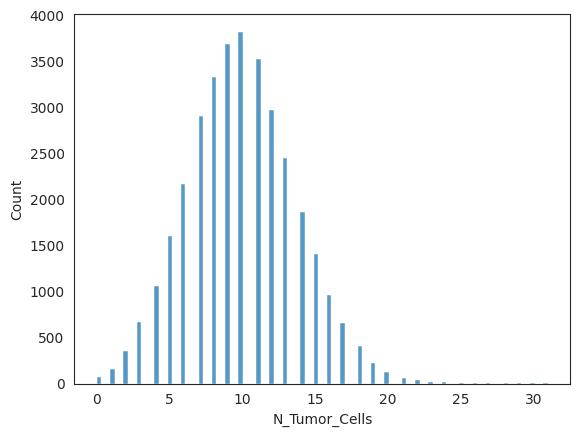

In [ ]:
sns.histplot(data=df1, x="N_Tumor_Cells")


Looks like most of the tumors cells in this Invasive Melanoma region  are sorrounded by 10 other tumor cells.

##4.4 Clustering tumor cells



BigQuery Geospatial analytics offers addtional functions that can be used to analysize spatial data. Here we used the function ST_CLUSTERDBSCAN function to identify spatial clusters of tumor cells. This function implements [the DBSCAN algorithm](https://en.wikipedia.org/wiki/DBSCAN) that identifies high-density clusters of data.

In [ ]:
query = """
WITH cells AS (
    SELECT CellID, X_centroid, Y_centroid,
      ST_GeogPoint(X_centroid/368570 ,Y_centroid/368570 ) as p
    FROM `isb-cgc-bq.HTAN.imaging_level4_HMS_mel_mask_current`
    WHERE HTAN_Biospecimen_ID='HTA7_1_3'
      AND X_centroid > 23076.9 AND X_centroid < 30384.6
      AND Y_centroid > 9615.3 AND Y_centroid < 15000
      AND SOX10_cellRingMask > 3704.5
      AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 )
)
SELECT CellID, X_centroid, Y_centroid, ST_CLUSTERDBSCAN(p, 20, 10) OVER () AS cluster_num
FROM cells
ORDER BY cluster_num
"""
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████|


,CellID,X_centroid,Y_centroid,cluster_num
0,427607,29516.163043,11655.445652,<NA>
1,451650,27167.407080,11971.176991,<NA>
2,455057,27320.621145,12022.070485,<NA>
3,334789,28309.099448,10379.027624,<NA>
4,690827,23460.790323,14693.612903,<NA>
...,...,...,...,...
34597,715741,23259.444976,14948.119617,8
34598,712444,23227.822222,14914.083333,8
34599,713926,23260.269962,14931.372624,8
34600,713625,23234.324324,14925.209459,8


The following code generates an image of the location of Tumor colored by the cluster they belong.

<ipython-input-27-3a974ec9e8c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cluster_num'] = df1['cluster_num'].astype(  str )


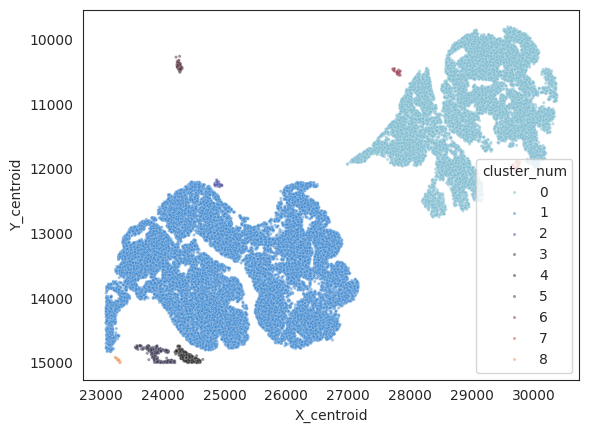

In [ ]:
df1 = df.dropna()
df1['cluster_num'] = df1['cluster_num'].astype(  str )

# Plot it
sns.set_style("white")
g=sns.scatterplot(data=df1, y="Y_centroid", x="X_centroid", hue='cluster_num', s=5,   alpha = 0.5 , palette="icefire")
g.invert_yaxis()

# 5. Relevant links and citations

*   [Link to the Manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and)
*   [Minerva Link showing an image of HTA7_1_3](https://labsyspharm.github.io/HTA-MELATLAS-1/stories/MEL1-full-story.html)
*   [Link with the functions available in BigQuery geospatial analyticis](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

